# # Keras API Project Exercise

The Data
We will be using a subset of the LendingClub DataSet obtained from Kaggle: https://www.kaggle.com/wordsforthewise/lending-club


LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California.[3] It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform.

Goal

Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), can we build a model thatcan predict wether or nor a borrower will pay back their loan? This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan. Keep in mind classification metrics when evaluating the performance of your model!

The "loan_status" column contains our label.

In [2]:
import pandas as pd

In [3]:
data_info = pd.read_csv('../DATA/lending_club_info.csv',index_col='LoanStatNew')

print(data_info.loc['revol_util']['Description'])

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


In [4]:
def feat_info(col_name):
    ## This function will provide the descripion of the column name that is called
    
    print(data_info.loc[col_name]['Description'])

In [5]:
feat_info('mort_acc')

Number of mortgage accounts.


# Import Libraries

In [691]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Reading data file

In [692]:
data = pd.read_csv('../DATA/lending_club_loan_two.csv')

In [693]:
data['earliest_cr_line']

0         Jun-1990
1         Jul-2004
2         Aug-2007
3         Sep-2006
4         Mar-1999
            ...   
396025    Nov-2004
396026    Feb-2006
396027    Mar-1997
396028    Nov-1990
396029    Sep-1998
Name: earliest_cr_line, Length: 396030, dtype: object

# Checking for distribution of studied data

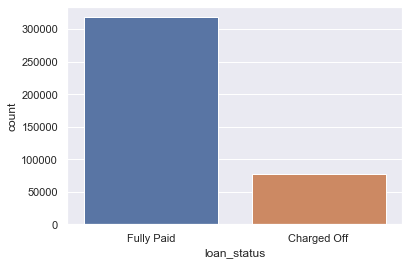

In [694]:
# Studing number of Distribution of Charge Off and Fully Paid Loans
sns.countplot(x ='loan_status',data=data)
# The data seems to be favouring loans that are fully paid. So we can expect our modelto struggle when it comes to predciting 
# Charged of loans compared to fully paid loans

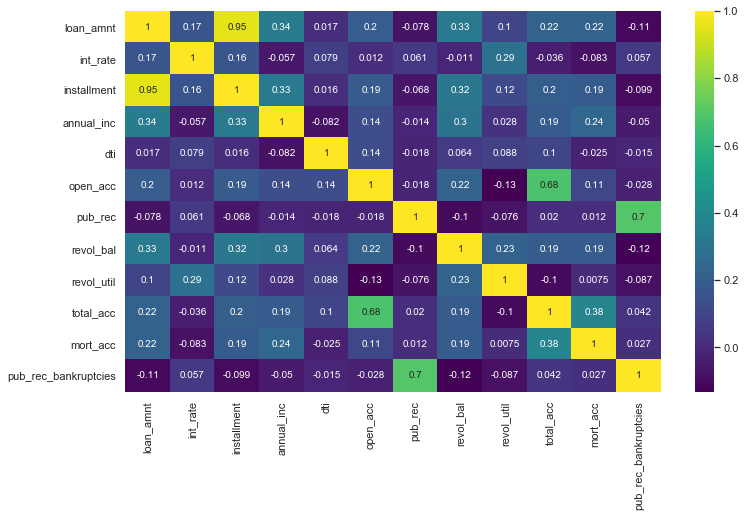

In [695]:
# Studying correlations between the data
plt.figure(figsize =(12,7))
sns.heatmap(data.corr().transpose(),cmap='viridis',annot=True)
# Strong correlation is observed between loan amount and interest instalment amount

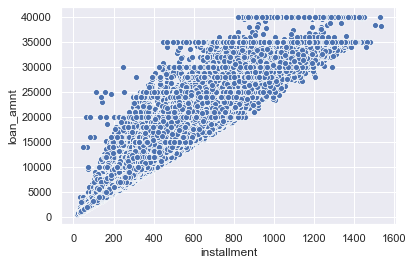

In [696]:
# Plotting scatter plot between the two strongly correlated values
sns.scatterplot(x ='installment',y = 'loan_amnt',data=data)

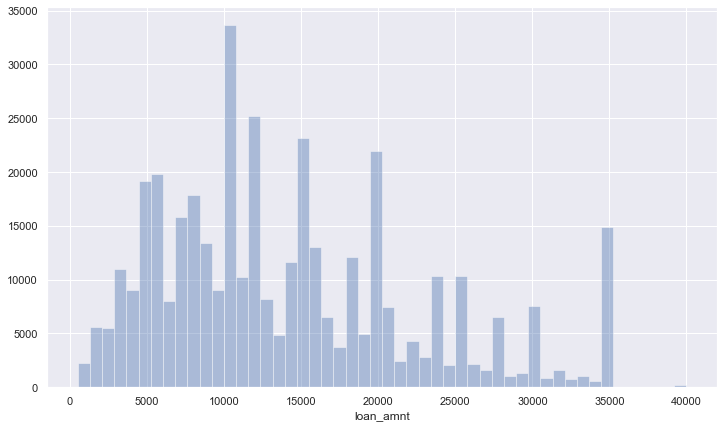

In [697]:
# Ploting histogram of loan amounts
plt.figure(figsize=(12,7))
sns.distplot(data['loan_amnt'],kde=False)

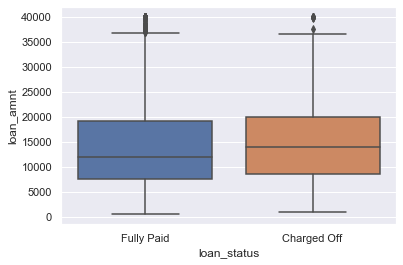

In [698]:
# Checking relationship between loan amount and charge off rates
sns.boxplot(x='loan_status',y='loan_amnt', data=data)
# data shows very little correlation between loan amount and the charge of rates

In [699]:
# Studying the values of the boxplot
data.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


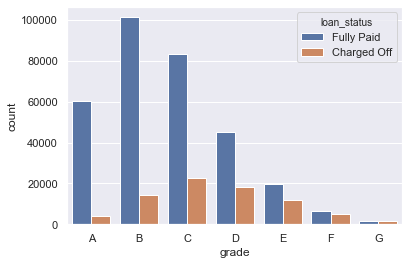

In [700]:
# Studying how loan grades are given 
sorted_grade = sorted(data['grade'].unique())
sns.countplot(x ='grade', data=data,hue='loan_status',order =sorted_grade)
# From the data it can be seen that the ratio of paid to unpaid loans are higher for grade F and G

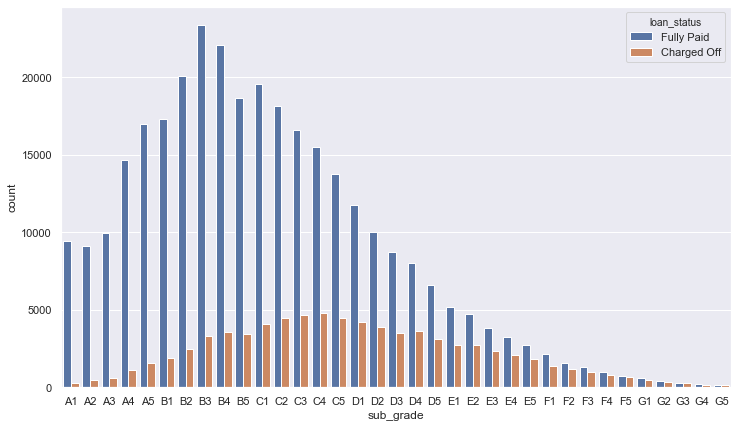

In [701]:
# Taking a look at subgrade
plt.figure(figsize=(12,7))
sorted_sub_grade =sorted(data['sub_grade'].unique())
sns.countplot(x = 'sub_grade',data=data,hue='loan_status',order =sorted_sub_grade)
# Subgrades also show the same trend of grade F and G having high paid to unpaid loan ratio

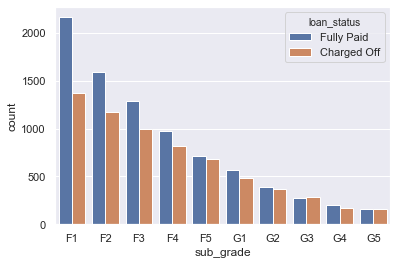

In [702]:
# Studying subgrade F and G closer
grade_data = data[(data['grade']=='F')| (data['grade'] =='G')]
sorted_grade_data =sorted(grade_data['sub_grade'].unique())
sns.countplot(x = 'sub_grade',data=grade_data,hue='loan_status',order = sorted_grade_data)

In [703]:
# Adding dummie columns for loan_status
data['loan_repaid'] =data['loan_status'].map({'Fully Paid': 1,'Charged Off':0})

# Data Pre-Processing

In [704]:
data.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [705]:
# Studying emp_title column
feat_info('emp_title')

The job title supplied by the Borrower when applying for the loan.*


In [706]:
data['emp_title'].nunique()
# There are to many titles to be assigning dummies to all of them so we can drop the column


173105

In [707]:
data = data.drop('emp_title', axis =1)

In [708]:
data.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [709]:
# Studying the emp_length column
feat_info('emp_length')

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 


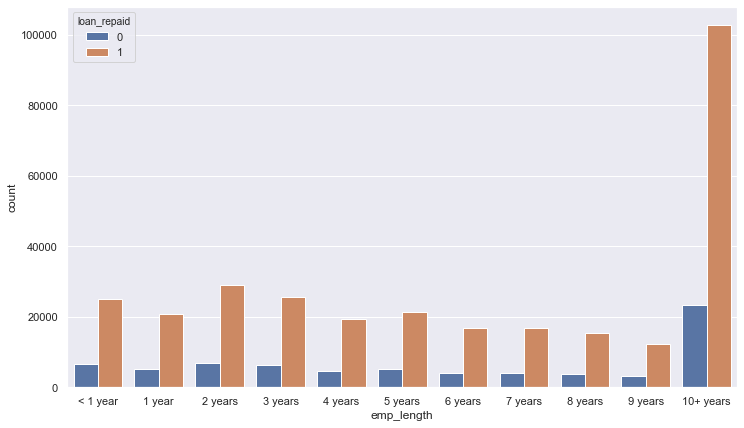

In [710]:
# Checking the distribution of employment length to default rates
sorted(data['emp_length'].dropna().unique())
sorted_list = [ '< 1 year','1 year','2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years','10+ years']
plt.figure(figsize=(12,7))
sns.countplot(x ='emp_length', data=data,hue ='loan_repaid',order = sorted_list)
# Data shows that the ration between paid and unpaid loans is similar for all employment lengths

In [711]:
# Calculating the ratios
emp_fp = data[data['loan_repaid']== 1].groupby('emp_length').count()['loan_repaid']
emp_co = data[data['loan_repaid']== 0].groupby('emp_length').count()['loan_repaid']

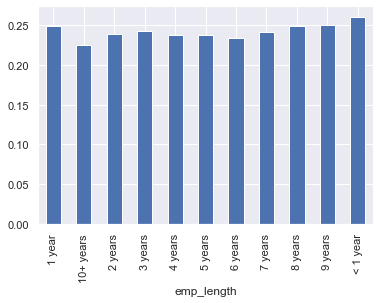

In [712]:
emp_ratio =(emp_co/emp_fp).plot(kind='bar')
# based on the data it can be seen that the ratio are equal between employment length and loan status 
# This inddicates that emp_length column is not an influencing variable and can be dropped

In [713]:
# Dropping emp_length column
data = data.drop('emp_length', axis =1)

In [714]:
data.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [715]:
# Studying the title column
feat_info('title')

The loan title provided by the borrower


In [716]:
len(data['title'].unique())
# There are to many different titles to create dummies 
# Drop the column

48818

In [717]:
data = data.drop('title', axis =1)

In [718]:
data.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [719]:
# Taing a look at mort_acc columns
feat_info('mort_acc')

Number of mortgage accounts.


In [720]:
# Determining which feature is mostly correlated to this feature
data.corr()['mort_acc']
# looks like the total_acc column has highest correalation to the mort_acc column

loan_amnt               0.222315
int_rate               -0.082583
installment             0.193694
annual_inc              0.236320
dti                    -0.025439
open_acc                0.109205
pub_rec                 0.011552
revol_bal               0.194925
revol_util              0.007514
total_acc               0.381072
mort_acc                1.000000
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
Name: mort_acc, dtype: float64

In [721]:
# Using total_acc column to determine mean mort_acc to fill missing values
mean_mort_acc = data.groupby('total_acc').mean()['mort_acc']

In [722]:
# Creating a function to run over data and make the changes
def mort_acc_fill(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return mean_mort_acc[total_acc]
    else:
        return mort_acc

In [723]:
data['mort_acc'] = data.apply(lambda x :mort_acc_fill( x['total_acc'],x['mort_acc']),axis =1)

In [724]:
data.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
home_ownership            0
annual_inc                0
verification_status       0
issue_d                   0
loan_status               0
purpose                   0
dti                       0
earliest_cr_line          0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              276
total_acc                 0
initial_list_status       0
application_type          0
mort_acc                  0
pub_rec_bankruptcies    535
address                   0
loan_repaid               0
dtype: int64

In [725]:
# Looking at revol_util and pub_rev_bankruptcies columns
len(data)


396030

In [726]:
(535+276)/len(data)*100
# Combined missing data from those two columns is <0.5% of the dataset . We can remove them for convinience

0.2047824659747999

In [727]:
# Removing data 
data =data.dropna()

In [728]:
data.isnull().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
loan_repaid             0
dtype: int64

# Converting catergorical data

In [729]:
# Determine all categorical columns
data.select_dtypes(['object']).columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

In [730]:
# Looking at the term grade
feat_info('term')
# This term has a binary type data

The number of payments on the loan. Values are in months and can be either 36 or 60.


In [731]:
data['term'] = data['term'].apply(lambda term: int(term[:3]))

In [732]:
# Looking at grade feature
# We know that grade is a part of sub grade so we can drop it
data =data.drop('grade',axis =1)

In [733]:
# Looking at sub_grade feature
# We need to get dummies for it
sub_grade_dummies =pd.get_dummies(data['sub_grade'],drop_first=True)

In [734]:
data =pd.concat([data.drop('sub_grade',axis =1),sub_grade_dummies], axis =1)

In [735]:
# Looking at home ownership
feat_info('home_ownership')

The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER


In [736]:
data['home_ownership'].value_counts()
# to reduce the number of dummies we can group others with non and any

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

In [737]:
data['home_ownership'] =data['home_ownership'].replace(['NONE','ANY'],'OTHER')

In [738]:
home_dummies = pd.get_dummies(data['home_ownership'],drop_first=True)
data = pd.concat([data.drop('home_ownership',axis=1),home_dummies],axis =1)

In [739]:
# Studying the address column
data['address']
# We will take the last digits to create a zipcode column
data['zipcode'] = data['address'].apply(lambda x : int(x[-5:]))

In [740]:
len(data['zipcode'].value_counts())
# There are a total of 10 unique zipcode which is alright to call dummies on it 

10

In [741]:
# Calling dummies on zipcode 
zip_dummies = pd.get_dummies(data['zipcode'],drop_first=True)
data = pd.concat([data.drop('zipcode',axis=1),zip_dummies],axis =1)

In [742]:
data = data.drop('address',axis =1)

In [743]:
# taking a look at verification status
feat_info('verification_status')

Indicates if income was verified by LC, not verified, or if the income source was verified


In [744]:
data['verification_status'].value_counts()

Verified           139451
Source Verified    131301
Not Verified       124467
Name: verification_status, dtype: int64

In [745]:
data['application_type'].value_counts()

INDIVIDUAL    394508
JOINT            425
DIRECT_PAY       286
Name: application_type, dtype: int64

In [746]:
data['purpose'].value_counts()

debt_consolidation    234169
credit_card            82923
home_improvement       23961
other                  21059
major_purchase          8756
small_business          5656
car                     4670
medical                 4175
moving                  2842
vacation                2442
house                   2197
wedding                 1794
renewable_energy         329
educational              246
Name: purpose, dtype: int64

In [747]:
data['initial_list_status'].value_counts()

f    237346
w    157873
Name: initial_list_status, dtype: int64

In [748]:
# Looking at the above variables ( initial_list_status, purpose, application_type and verification) all are good for conversion
# Getting dummies
group_dummies = pd.get_dummies(data[['verification_status','application_type','initial_list_status', 'purpose']],drop_first=True)
data = pd.concat([data.drop(['verification_status','application_type','initial_list_status', 'purpose'],axis=1),group_dummies],axis=1)

In [749]:
data.head()

,loan_amnt,term,int_rate,installment,annual_inc,issue_d,loan_status,dti,earliest_cr_line,open_acc,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,10000.0,36,11.44,329.48,117000.0,Jan-2015,Fully Paid,26.24,Jun-1990,16.0,...,0,0,0,0,0,0,0,0,1,0
1,8000.0,36,11.99,265.68,65000.0,Jan-2015,Fully Paid,22.05,Jul-2004,17.0,...,0,0,0,0,0,0,0,0,0,0
2,15600.0,36,10.49,506.97,43057.0,Jan-2015,Fully Paid,12.79,Aug-2007,13.0,...,0,0,0,0,0,0,0,0,0,0
3,7200.0,36,6.49,220.65,54000.0,Nov-2014,Fully Paid,2.60,Sep-2006,6.0,...,0,0,0,0,0,0,0,0,0,0
4,24375.0,60,17.27,609.33,55000.0,Apr-2013,Charged Off,33.95,Mar-1999,13.0,...,0,0,0,0,0,0,0,0,0,0


In [750]:
data['loan_status']

0          Fully Paid
1          Fully Paid
2          Fully Paid
3          Fully Paid
4         Charged Off
             ...     
396025     Fully Paid
396026     Fully Paid
396027     Fully Paid
396028     Fully Paid
396029     Fully Paid
Name: loan_status, Length: 395219, dtype: object

In [751]:
# Dropping loan status clomuns
data = data.drop('loan_status',axis =1)

In [752]:
data['loan_repaid']

0         1
1         1
2         1
3         1
4         0
         ..
396025    1
396026    1
396027    1
396028    1
396029    1
Name: loan_repaid, Length: 395219, dtype: int64

In [753]:
data.select_dtypes(['object']).columns

Index(['issue_d', 'earliest_cr_line'], dtype='object')

In [754]:
# For the issue_d , for this model we are trying to predict if a person will default on his loan prior to giving the loan. 
# Having an issue date defeats the purpose and we should drop it
data=data.drop('issue_d',axis=1)

In [755]:
# Looking at earliest credit line
feat_info('earliest_cr_line')

The month the borrower's earliest reported credit line was opened


In [756]:
data['earliest_cr_line'] = data['earliest_cr_line'].apply(lambda date: int(date[-4:]))

In [757]:
data['earliest_cr_line']

0         1990
1         2004
2         2007
3         2006
4         1999
          ... 
396025    2004
396026    2006
396027    1997
396028    1990
396029    1998
Name: earliest_cr_line, Length: 395219, dtype: int64

In [758]:
data.columns

Index([                          'loan_amnt',
                                      'term',
                                  'int_rate',
                               'installment',
                                'annual_inc',
                                       'dti',
                          'earliest_cr_line',
                                  'open_acc',
                                   'pub_rec',
                                 'revol_bal',
                                'revol_util',
                                 'total_acc',
                                  'mort_acc',
                      'pub_rec_bankruptcies',
                               'loan_repaid',
                                        'A2',
                                        'A3',
                                        'A4',
                                        'A5',
                                        'B1',
                                        'B2',
                                  

# Data processing

In [759]:
from sklearn.model_selection import train_test_split

In [774]:
# Specifying variables
X = data.drop('loan_repaid', axis=1).values
y = data['loan_repaid'].values


In [775]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


# Normalizing Data

In [776]:
from sklearn.preprocessing import MinMaxScaler

In [777]:
scaler = MinMaxScaler()

In [778]:
X_train =scaler.fit_transform(X_train)

In [779]:
X_test = scaler.transform(X_test)

# Building  a model

In [780]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [781]:
model = Sequential()

In [782]:
model.add(Dense(78,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(39,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(19,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss ='binary_crossentropy',optimizer='adam')

In [783]:
model.fit(X_train,y_train,epochs=25,batch_size=256,validation_data=(X_test,y_test))

Train on 316175 samples, validate on 79044 samples
Epoch 1/25
316175/316175 [==============================] - 9s 28us/sample - loss: 0.2978 - val_loss: 0.2650
Epoch 2/25
316175/316175 [==============================] - 7s 22us/sample - loss: 0.2655 - val_loss: 0.2628
Epoch 3/25
316175/316175 [==============================] - 7s 23us/sample - loss: 0.2625 - val_loss: 0.2624
Epoch 4/25
316175/316175 [==============================] - 6s 20us/sample - loss: 0.2617 - val_loss: 0.2619
Epoch 5/25
316175/316175 [==============================] - 4s 14us/sample - loss: 0.2607 - val_loss: 0.2624
Epoch 6/25
316175/316175 [==============================] - 4s 14us/sample - loss: 0.2602 - val_loss: 0.2623
Epoch 7/25
316175/316175 [==============================] - 4s 14us/sample - loss: 0.2601 - val_loss: 0.2618
Epoch 8/25
316175/316175 [==============================] - 4s 14us/sample - loss: 0.2594 - val_loss: 0.2612
Epoch 9/25
316175/316175 [==============================] - 4s 14us/sample - 

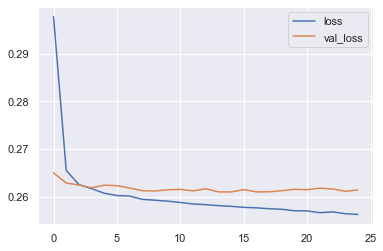

In [785]:
pd.DataFrame(model.history.history).plot()

In [786]:
from sklearn.metrics import confusion_matrix,classification_report

In [790]:
predictions =model.predict_classes(X_test)

In [791]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      0.43      0.60     15658
           1       0.88      1.00      0.93     63386

    accuracy                           0.89     79044
   macro avg       0.93      0.72      0.77     79044
weighted avg       0.90      0.89      0.87     79044

[[ 6798  8860]
 [   74 63312]]
